In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re                    
import spacy              
from nltk import tokenize 
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
%matplotlib inline

The data file for you to analyze is in the assignment in Canvas. For the purposes of the questions below, you can ignore the unit_state, sentiment_gold and sentiment_gold_reason fields, as only a few of the observations have been tagged this way, although you may find it instructive to compare the automatically calculated sentiment to the human-generated sentiment_gold and sentiment_gold_reason field where they are available).

In [141]:
data = pd.read_csv('Twitter-sentiment-self-drive-DFE.csv')

In [142]:
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,our_id,sentiment_gold,sentiment_gold_reason,text
0,724227031,True,golden,236,NaN,5,0.7579,10001,5\n4,Author is excited about the development of the...,Two places I'd invest all my money if I could:...
1,724227032,True,golden,231,NaN,5,0.8775,10002,5\n4,Author is excited that driverless cars will be...,Awesome! Google driverless cars will help the ...
2,724227033,True,golden,233,NaN,2,0.6805,10003,2\n1,The author is skeptical of the safety and reli...,If Google maps can't keep up with road constru...
3,724227034,True,golden,240,NaN,2,0.8820,10004,2\n1,The author is skeptical of the project's value.,Autonomous cars seem way overhyped given the t...
4,724227035,True,golden,240,NaN,3,1.0000,10005,3,Author is making an observation without expres...,Just saw Google self-driving car on I-34. It w...


## Question 1 

#### 1) Perform exploratory data analysis (for example summary statistics and histograms on the numeric fields) on the data and indicate if you foresee any problems using the data to build a model to predict sentiment. (5 points)

In [143]:
data.head()
data.shape

(7156, 11)

In [144]:
data.describe()

,_unit_id,_trusted_judgments,sentiment:confidence,our_id
count,7.156000e+03,7156.000000,7156.000000,7156.000000
mean,7.243474e+08,5.834405,0.774654,3609.930548
std,2.506742e+05,11.144930,0.205363,2140.401611
min,7.242270e+08,1.000000,0.248000,1.000000
25%,7.243229e+08,3.000000,0.630600,1789.750000
50%,7.243247e+08,4.000000,0.753100,3578.500000
75%,7.243265e+08,8.000000,1.000000,5367.250000
max,7.269423e+08,241.000000,1.000000,10077.000000


In [145]:
data.isnull().sum()

_unit_id                    0
_golden                     0
_unit_state                 0
_trusted_judgments          0
_last_judgment_at          77
sentiment                   0
sentiment:confidence        0
our_id                      0
sentiment_gold           7079
sentiment_gold_reason    7079
text                        0
dtype: int64

#### Dropping the columns - '_unit state', '_golden', 'sentiment_gold_reason', 'sentiment_gold'

In [146]:
data.drop(['_unit_state','_golden', 'sentiment_gold_reason','sentiment_gold'], axis=1, inplace=True)

#### Dropping all the rows that have the sentiment as 'not relevant'

In [147]:
data.drop(data[data['sentiment']=='not_relevant'].index, inplace=True)

In [148]:
data.isnull().sum()

_unit_id                 0
_trusted_judgments       0
_last_judgment_at       64
sentiment                0
sentiment:confidence     0
our_id                   0
text                     0
dtype: int64

#### Dropping the column our_id as it is not indicative of any aspect of our objective

In [149]:
data.drop('our_id', axis=1, inplace=True)

#### Dropping the columns _last_judgement_at as the date of the last judgement isn't indicative of the sentiment of the tweets and it has null values. 

In [150]:
data.rename(columns={'_unit_id': 'ID'}, inplace=True)
data.drop('_last_judgment_at', axis=1, inplace=True)
data.head()

,ID,_trusted_judgments,sentiment,sentiment:confidence,text
0,724227031,236,5,0.7579,Two places I'd invest all my money if I could:...
1,724227032,231,5,0.8775,Awesome! Google driverless cars will help the ...
2,724227033,233,2,0.6805,If Google maps can't keep up with road constru...
3,724227034,240,2,0.8820,Autonomous cars seem way overhyped given the t...
4,724227035,240,3,1.0000,Just saw Google self-driving car on I-34. It w...


#### Converting the type of the column 'sentiment' to int from string

In [151]:
data['sentiment'].unique()
for i in range(len(data)):
    data.iloc[i,2]=int(data.iloc[i,2])

#### Drop duplicate tweets based on the 'text' field

In [152]:
print(len(data[data['text'].duplicated()==True]))
data.drop_duplicates(subset=['text'], keep='first', inplace=True, ignore_index=False)
len(data)

10


6933

#### Removing the links from the tweets

In [153]:
for i in range(0, len(data)):
    data.iloc[i,4] = re.sub(r"http\S+", "", data.iloc[i, 4])

In [154]:
#Generating profile report to analyse the column data

from pandas_profiling import ProfileReport
#profile = ProfileReport(data)
#profile

### From the profile report generated, we can see that there are no missing values in our dataset. It is also clear that there seems to be some correlationn between the number of trusted judgements and the sentiment confidence. 

we will explore these aspects in more detail

#### Plotting a bar graph of the sentiment of the tweets

             ID
sentiment      
1           110
2           685
3          4236
4          1443
5           459


<Figure size 1440x1440 with 0 Axes>

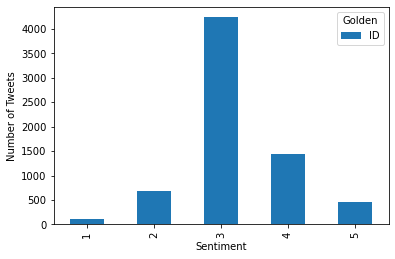

In [156]:
temporary = data.pivot_table(values='ID', index='sentiment', aggfunc='count', fill_value=0)
print(temporary)

plt.figure(figsize=(20,20))
temporary.plot(kind='bar', stacked=True)
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.legend(title='Golden')
plt.show()

#### The plotted histogram is indicative of the fact that most of the tweets in the dataset are neutral in nature. This could be a potential problem, because most of the neutral tweets are news article headlines, statements made about the car's features, etc. These tweets do not help in accessing sentiment. 

#### Also, there is a clear class imbalance as there are many tweets of sentiment category '3' as comapred to the other sentiment categories. This will lead to an imbalance in model building

#### Plotting a histogram of the 'trusted_judgments' columns to understand the frequency distribution

(array([ 0.,  0.,  0.,  0.,  4., 17., 28.,  5.,  0.,  0.,  0.,  9.]),
 array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 150, 200, 250]),
 <BarContainer object of 12 artists>)

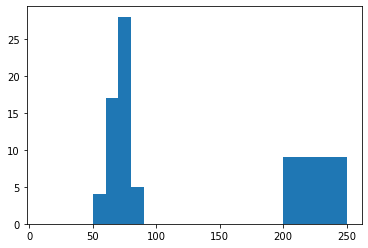

In [157]:
plt.hist(data['_trusted_judgments'], bins=[10,20,30,40,50,60,70,80, 90, 100, 150, 200, 250])

#### From the above histogram, we can see that most of the tweets have a range of 50-100 when it comes to the number of people trusting the tweet. However, there are a few tweets that have more than 200 trusted judgements. We can use this data later, to extract the sentiments from the highly trusted tweets

<AxesSubplot:xlabel='_trusted_judgments', ylabel='sentiment:confidence'>

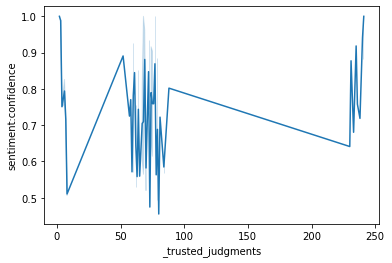

In [158]:
sns.lineplot(x=data['_trusted_judgments'], y=data['sentiment:confidence'])

#### After plotting the data, we can see that there isn't much correlation between the sentiment confidence and the number of trusted judgements

<AxesSubplot:>

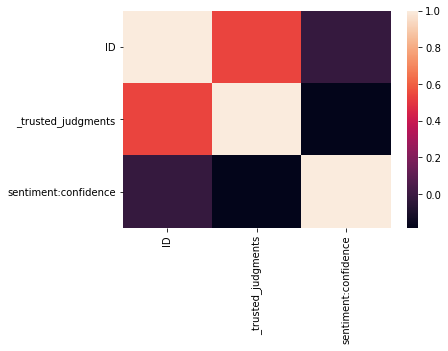

In [159]:
sns.heatmap(data.corr())

(array([  18.,  419.,   16.,  881.,  231.,  396., 2231.,   57.,   11.,
        2673.]),
 array([0.2505 , 0.32545, 0.4004 , 0.47535, 0.5503 , 0.62525, 0.7002 ,
        0.77515, 0.8501 , 0.92505, 1.     ]),
 <BarContainer object of 10 artists>)

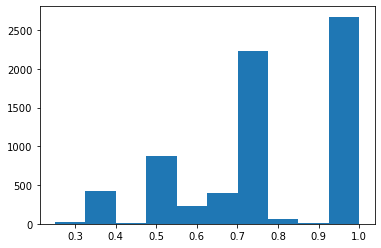

In [160]:
plt.hist(data['sentiment:confidence'])

<AxesSubplot:xlabel='sentiment', ylabel='sentiment:confidence'>

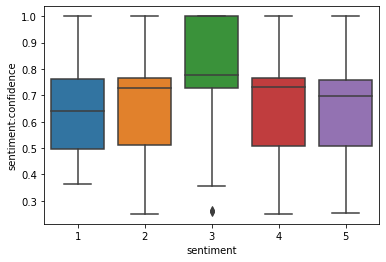

In [161]:
sns.boxplot(x=data['sentiment'], y=data['sentiment:confidence'])

#### We can see that most of the tweets that have a sentiment score of 1, 2, 4 and 5 usually have a confidence of 0.5-0.8. However, tweets that have a sentiment of 3 usually have high confidence associated with it. 

### Indicate if you foresee any problems using the data to build a model to predict sentiment.

- There is a clear class imbalance in the data, with respect to the number of tweets that have a sentiment rating of 3 as compared to the other classes. This could be a potential problem in building a model using this data to predict sentiment. 
- We had to get rid of all the null value rows and columns before we could build a model to predict sentiment, as null values could've created issues
- There were a lot of columns that weren't helpful in predicting the sentiment of the tweets, so we dropped all such columns
- We tried to find correlation between the important features, but there wasn't much of a dependence between the features
- We dropped duplicate tweets, because that would've trained our model in a rather wrong way. Duplicate tweets had different sentiment scores. We dropped all but the first
- We removed all of the 'not-relevant' tweets before building our model. 

Apart from these, there are no further problems and we can now build our model to predict sentiment


## Question 2

#### 2) Tokenize the Tweets for analysis (words, and punctuation, e.g. "!!!", will be relevant). Show the most common words/tokens overall, nouns, adjectives, and punctuation-based tokens for all of the tweets. You should exclude stopwords and the frequent words/phrases like “self- driving cars” that do not help in the prediction task. (Note: if you decide to stem or lemmatize the words for modeling in the following step, which is recommended, you should do that after the part of speech tagging in this step.) (5 points)

#### In this step, we tokenize the tweets and remove all the stop words and we remove all the tokens that aren't alphanumeric

In [162]:
import string

tknzr = TweetTokenizer()

##Cleaning the tokens to remove stop words

tweets = data['text'].to_numpy()
nlp = spacy.load('en_core_web_sm')

#Tokenize tweets with NTLK's TweetTokenizer
stopwords_tweets = []
t_tokenizer = TweetTokenizer()

##Cleaning the tweets for stop words
for tw in tweets:
    cleaned = [word for word in t_tokenizer.tokenize(tw.lower()) if word not in nlp.Defaults.stop_words and (word in string.punctuation or str.isalnum(word))]
    stopwords_tweets.append(' '.join(cleaned))

#### We use the CountVectorizer to find all the words that are most frequent and if they are relevant to our sentiment predicting model

In [165]:
from sklearn.feature_extraction.text import CountVectorizer

def get_common_words(temp, n=None):
    vector = CountVectorizer().fit(temp)
    bag = vector.transform(temp)
    total_words = bag.sum(axis=0) 
    words_count = [(word, total_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    words_count = sorted(words_count, key = lambda x: x[1], reverse=True)
    return words_count[:n]

common_words = get_common_words(stopwords_tweets, 20)
for word, freq in common_words:
    print(word, freq)


car 3589
cars 3192
google 2106
driverless 1803
driving 1705
self 1460
autonomous 356
future 303
saw 282
like 265
drive 245
new 233
rt 219
vehicle 198
need 192
california 188
uber 186
think 182
want 173
road 166


#### Cleaning the tweets for similar meaning words like 'self-driving', 'autonomous', 'driverless'

In [166]:
cleaned_tweets = []
similar_words =['self-driving', 'autonomous', 'driverless', 'automated', 'vehicle', 'car', 'cars', 'vehicles', 'self', 'driving', 'google', 'uber', 'audi','rt', 'self', 'drive', 'california']
for tw in stopwords_tweets:
    cleaned = [word for word in t_tokenizer.tokenize(tw.lower()) if word not in similar_words]
    cleaned_tweets.append(' '.join(cleaned))

##Inserting the clean tokens to our original dataframe
data.insert(5, 'Cleaned', cleaned_tweets)
data.head()

,ID,_trusted_judgments,sentiment,sentiment:confidence,text,Cleaned
0,724227031,236,5,0.7579,Two places I'd invest all my money if I could:...,places invest money : 3d printing ! ! !
1,724227032,231,5,0.8775,Awesome! Google driverless cars will help the ...,awesome ! help blind travel ;
2,724227033,233,2,0.6805,If Google maps can't keep up with road constru...,"maps road construction , supposed trust ?"
3,724227034,240,2,0.8820,Autonomous cars seem way overhyped given the t...,way overhyped given technology challenges ; pi...
4,724227035,240,3,1.0000,Just saw Google self-driving car on I-34. It w...,saw - 34 . painted green blue .


#### Lemmatizing the cleaned data using spaCy.lemma_

In [167]:
import spacy
nlp = spacy.load("en_core_web_sm")

lemma = []

for i in range(0,len(data)):  
    doc = nlp(data.iloc[i,5])
    words = " ".join([token.lemma_ for token in doc])
    lemma.append(words)

data.insert(6, 'Spacy_Lemma', lemma)
data.head()

,ID,_trusted_judgments,sentiment,sentiment:confidence,text,Cleaned,Spacy_Lemma
0,724227031,236,5,0.7579,Two places I'd invest all my money if I could:...,places invest money : 3d printing ! ! !,place invest money : 3d print ! ! !
1,724227032,231,5,0.8775,Awesome! Google driverless cars will help the ...,awesome ! help blind travel ;,awesome ! help blind travel ;
2,724227033,233,2,0.6805,If Google maps can't keep up with road constru...,"maps road construction , supposed trust ?","map road construction , suppose trust ?"
3,724227034,240,2,0.8820,Autonomous cars seem way overhyped given the t...,way overhyped given technology challenges ; pi...,way overhype give technology challenge ; pilot...
4,724227035,240,3,1.0000,Just saw Google self-driving car on I-34. It w...,saw - 34 . painted green blue .,see - 34 . paint green blue .


In [168]:
temp = data.copy()

#### The next step is to tag the parts of speech to the clean tokens

#### I used spacy.lemma_ to lemmatize the data. As spaCy determines the part-of-speech tag by default and assigns the corresponding lemma, the POS tagging is done here only to emphasize it's pattern. By using spaCy to lemmatize the data in the previous cell, we don't need to tag the POS.

In [169]:
##Part of Speech tagging

POS_tagged =[]

for i in range(0,len(data)):  
    wordsList = nltk.word_tokenize(data.iloc[i,6])
    tagged = nltk.pos_tag(wordsList)
    POS_tagged.append(tagged)

data.insert(7, 'POS', POS_tagged)
data.head()

,ID,_trusted_judgments,sentiment,sentiment:confidence,text,Cleaned,Spacy_Lemma,POS
0,724227031,236,5,0.7579,Two places I'd invest all my money if I could:...,places invest money : 3d printing ! ! !,place invest money : 3d print ! ! !,"[(place, NN), (invest, JJS), (money, NN), (:, ..."
1,724227032,231,5,0.8775,Awesome! Google driverless cars will help the ...,awesome ! help blind travel ;,awesome ! help blind travel ;,"[(awesome, NN), (!, .), (help, NN), (blind, VB..."
2,724227033,233,2,0.6805,If Google maps can't keep up with road constru...,"maps road construction , supposed trust ?","map road construction , suppose trust ?","[(map, NN), (road, NN), (construction, NN), (,..."
3,724227034,240,2,0.8820,Autonomous cars seem way overhyped given the t...,way overhyped given technology challenges ; pi...,way overhype give technology challenge ; pilot...,"[(way, NN), (overhype, JJ), (give, JJ), (techn..."
4,724227035,240,3,1.0000,Just saw Google self-driving car on I-34. It w...,saw - 34 . painted green blue .,see - 34 . paint green blue .,"[(see, VB), (-, :), (34, CD), (., .), (paint, ..."


#### Printing the tweet, cleaned tweet and lemmatized form of a random tweet

In [171]:
print(data['text'][0])
print(data['Cleaned'][0])
print(data['Spacy_Lemma'][0])
print(data['POS'][0])

Two places I'd invest all my money if I could: 3D printing and Self-driving cars!!!
places invest money : 3d printing ! ! !
place invest money : 3d print ! ! !
[('place', 'NN'), ('invest', 'JJS'), ('money', 'NN'), (':', ':'), ('3d', 'CD'), ('print', 'NN'), ('!', '.'), ('!', '.'), ('!', '.')]


### Show the most common words/tokens overall, nouns, adjectives, and punctuation-based tokens for all of the tweets. 

In [172]:
##Most Frequent word from the original tweets

from collections import Counter
data_tweet = data['text'].tolist()    
print("Most common word from the original tweets - ")

data_tweet = ' '.join(data_tweet)    
split_it = data_tweet.split()
Counter = Counter(split_it)
most_occur = Counter.most_common(5)
print(*most_occur,sep='\n')

Most common word from the original tweets - 
('the', 2812)
('car', 2194)
('a', 2123)
('to', 2062)
('cars', 1926)


In [173]:
import string

def cleaning(text):        
    # converting to lowercase, removing URL links, special characters, punctuations...
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)     

    # removing the emojies              
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)   
    
    return text

In [174]:
##Most Frequent word from the cleaned tweets

from collections import Counter
data_cleaned = data['Cleaned'].tolist()
print("Most common word from the Cleaned tweets - ")

temp_col = data['Cleaned'].apply(cleaning)

data_cleaned = ' '.join(temp_col)    
split_it = data_cleaned.split()
Counter = Counter(split_it)
most_occur = Counter.most_common(5)

print(*most_occur,sep='\n')

Most common word from the Cleaned tweets - 
('future', 303)
('s', 301)
('saw', 282)
('like', 265)
('new', 233)


In [175]:
##Sorting all the cleaned tokens into their part of speech list using spacy.pos_

noun_list = []
verb_list = []
adj_list = []
adv_list = []


for i in range(0,len(data)):  
    doc = nlp(data.iloc[i,5])
    for token in doc:
        if token.pos_ =='NOUN':
            noun_list.append(token)
        elif token.pos_ == 'VERB':
            verb_list.append(token)
        elif token.pos_ == 'ADJ':
            adj_list.append(token)
        elif token.pos_ == 'ADV':
            adv_list.append(token)

In [176]:
for i in range(len(noun_list)):
    noun_list[i]=noun_list[i].text
    noun_list[i] = cleaning(noun_list[i])

for i in range(len(verb_list)):
    verb_list[i]=verb_list[i].text
    verb_list[i] = cleaning(verb_list[i])
    
for i in range(len(adj_list)):
    adj_list[i]=adj_list[i].text
    adj_list[i] = cleaning(adj_list[i])

for i in range(len(adv_list)):
    adv_list[i]=adv_list[i].text
    adv_list[i] = cleaning(adv_list[i])

In [177]:
##Most Frequent Noun

from collections import Counter
print("Most frequent Noun - ")
noun = '' 
for i in range(len(noun_list)):
    noun += ' '+noun_list[i]
split_it = noun.split()
Counter = Counter(split_it)
most_occur = Counter.most_common(5)
print(*most_occur,sep='\n')

Most frequent Noun - 
('future', 166)
('road', 155)
('people', 154)
('today', 152)
('wheel', 144)


In [178]:
##Most Frequent Adjective

from collections import Counter
print("Most frequent Adjective - ")
adj = '' 
for i in range(len(adj_list)):
    adj += ' '+adj_list[i]
split_it = adj.split()
Counter = Counter(split_it)
most_occur = Counter.most_common(5)
print(*most_occur,sep='\n')

Most frequent Adjective - 
('new', 212)
('future', 133)
('ready', 86)
('good', 84)
('cool', 82)


In [179]:
## Most Frequent Verb

from collections import Counter
print("Most frequent Verb  - ")
verb = '' 
for i in range(len(verb_list)):
    verb += ' '+verb_list[i]
split_it = verb.split()
Counter = Counter(split_it)
most_occur = Counter.most_common(5)
print(*most_occur,sep='\n')

Most frequent Verb  - 
('saw', 277)
('think', 176)
('want', 159)
('going', 129)
('wait', 125)


In [180]:
## Most Frequent Adverb

from collections import Counter
print("Most frequent Adverb  - ")
adv = '' 
for i in range(len(adv_list)):
    adv += ' '+adv_list[i]
split_it = adv.split()
Counter = Counter(split_it)
most_occur = Counter.most_common(5)
print(*most_occur,sep='\n')

Most frequent Adverb  - 
('soon', 108)
('pretty', 47)
('maybe', 44)
('probably', 33)
('actually', 32)


In [181]:
## Most Frequent Punctuation Calculation

import string

punct =[]

keywords = string.punctuation

for i in range(len(data)):
    words = data.iloc[i,6].lower().split()
    for w in words:
        if w in string.punctuation and words[words.index(w)-1] not in string.punctuation:
            punct.append(words[words.index(w)-1])
            
from collections import Counter
punct = ' '.join(punct)     
split_it = punct.split()
Counter = Counter(split_it)
most_occur = Counter.most_common(5)
print(*most_occur,sep='\n')

('future', 158)
('see', 125)
('today', 103)
('driver', 103)
('year', 88)


### After tokenizing and lemmatizing the data - most common words/tokens overall, nouns, adjectives, and punctuation-based tokens for all of the tweets.

- Most Common Word (Original Data) - 'the'
- Most Common Word (Cleaned Data - after removing stopwords) - 'future'
- Nouns - 'future'
- Adjectives - 'new'
- Verb - 'saw'
- Adverb - 'soon'
- Punctuation based tokens - 'future'

### QUESTION 4

#### Create a model to predict what sentiment a Tweet will be given on the 1-5 scale. What are the 10 top words/tokens for each sentiment rating? (5 points) 

### Building a model to classify tweets according to the sentiment scale using TF-IDF method

In [182]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = data['text']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()
print(X.shape)

(6933, 11224)


In [183]:
temp= temp.astype({'sentiment':'int64'})

In [184]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train, Y_test = train_test_split(temp['Spacy_Lemma'], temp['sentiment'], test_size=0.3, random_state=30)

print('Train: ',X_train.shape,Y_train.shape,'\nTest:  ',X_test.shape,Y_test.shape)


Train:  (4853,) (4853,) 
Test:   (2080,) (2080,)


In [185]:
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

### Using Logistic Regression to test the model by splitting the dataset into training and testing sets

In [186]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000,solver='saga')
clf.fit(tf_x_train,Y_train)

LogisticRegression(max_iter=1000, solver='saga')

In [187]:
y_test_pred=clf.predict(tf_x_test)

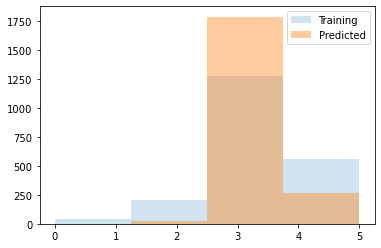

In [209]:
bins = np.linspace(0, 5, 5)



plt.hist(Y_test, bins, alpha=0.2, label='Training')
plt.hist(y_test_pred, bins, alpha=0.4, label='Predicted')
plt.legend(loc='upper right')
plt.show()

### To capture the most common words for each sentiment rating, we need to remove all the punctuation tokens. 

In [188]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

data["No_Punct"] = data['Spacy_Lemma'].apply(remove_punctuations)

### List of top 10 words for each sentiment rating

In [191]:
temp_col = []

for i in range(len(data['sentiment'].unique())):
    for j in range(len(data)):
        if data.iloc[j, 2]==i+1:
            temp_col.append(data.iloc[j,8])
    data_cleaned = ' '.join(temp_col)
    split_it = data_cleaned.split()
    from collections import Counter
    Counter = Counter(split_it)
    most_occur = Counter.most_common(10)
    print("\n 10 Most Common words for sentiment rating -", i+1)
    print(*most_occur,sep='\n')



 10 Most Common words for sentiment rating - 1
('think', 11)
('want', 9)
('people', 9)
('crash', 7)
('fuck', 7)
('go', 7)
('way', 7)
('wheel', 7)
('idea', 7)
('driver', 6)

 10 Most Common words for sentiment rating - 2
('think', 56)
('like', 51)
('go', 46)
('driver', 45)
('people', 42)
('want', 38)
('need', 36)
('road', 32)
('t', 32)
('s', 30)

 10 Most Common words for sentiment rating - 3
('see', 240)
('s', 228)
('future', 204)
('road', 203)
('like', 194)
('new', 184)
('think', 184)
('driver', 164)
('need', 150)
('look', 146)

 10 Most Common words for sentiment rating - 4
('see', 340)
('s', 283)
('future', 281)
('like', 249)
('road', 248)
('need', 241)
('think', 239)
('driver', 231)
('new', 223)
('look', 204)

 10 Most Common words for sentiment rating - 5
('see', 373)
('s', 309)
('future', 303)
('like', 268)
('road', 261)
('need', 257)
('think', 246)
('driver', 241)
('new', 240)
('want', 220)


## Question 5

### 5) Evaluate how well the model performs for each rating (1-5).  

### Testing the accuracy of the model

In [192]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report
report=classification_report(Y_test, y_test_pred,output_dict=True)

for key, value in report.items():
        print('Performance Metric -', key)
        print(value)
        print('\n')

Performance Metric - 1
{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 41}


Performance Metric - 2
{'precision': 0.4583333333333333, 'recall': 0.05392156862745098, 'f1-score': 0.09649122807017545, 'support': 204}


Performance Metric - 3
{'precision': 0.6815892557358701, 'recall': 0.9545454545454546, 'f1-score': 0.7952987267384918, 'support': 1276}


Performance Metric - 4
{'precision': 0.48, 'recall': 0.273972602739726, 'f1-score': 0.34883720930232553, 'support': 438}


Performance Metric - 5
{'precision': 0.5789473684210527, 'recall': 0.09090909090909091, 'f1-score': 0.15714285714285714, 'support': 121}


Performance Metric - accuracy
0.6538461538461539


Performance Metric - macro avg
{'precision': 0.43977399149805124, 'recall': 0.27466974336434447, 'f1-score': 0.2795540042507699, 'support': 2080}


Performance Metric - weighted avg
{'precision': 0.5978367893739988, 'recall': 0.6538461538461539, 'f1-score': 0.5799472929006422, 'support': 2080}




### Where does it make errors and how might you improve it? (5 points) 

- We can see that the overall accuracy of the model is 65%
- We can also notice that the overall performance of the model for the sentiment rating '3' is better as compared to all the other sentiment ratings. This is because the number of tweets with the rating of '3' were much higher as compared to that of the other ratings. This is a classic case of class imbalance, and that is one of the primary aspects that can be changed to improve the quality of the model. 
- We are training the model based on 1 feature. That could also be a reason for low accuracy score of our model. If we can include more features to buid our classification model, that would definitely increase accuracy. 